In [99]:
import easyocr
from ultralytics import YOLO
import numpy as np

reader = easyocr.Reader(['en'])
model = YOLO("best.pt")
class_name = "snelheid"
MAX_SPEED = 120

def get_bbox(results, class_name):
    """
    Kijkt voor een gegeven class of er bounding
    boxes zijn gevonden.
    """
    # Kijken of alle items correct zijn
    for result in results:
        if hasattr(result, 'names') and hasattr(result, 'boxes'):
            # Zoeken van de class index
            class_index = None
            for index, name in result.names.items():
                if name == class_name:
                    class_index = index
                    break
            
            # Ga door als de class_index niet is gevonden
            if class_index is None:
                continue
            
            # Ophalven van de box voor de class
            for box in result.boxes:
                if box.cls == class_index:
                    # Ophalen van de box coordinaten
                    x1, y1, x2, y2 = box.xyxy[0]
                    width = x2 - x1
                    height = y2 - y1
                    return [x1, y1, width, height]
    
    # Return None als er geen box van die class is gevonden
    return None


def crop_bbox(image, bbox):
    """
    Snijd de bounding box uit de afbeelding en returnd
    de gesneden afbeelding.

    Parameters:
    - image: De originele afbeelding
    - bbox: De bounding box in de volgende vorm: [x, y, width, height].

    Returns:
    - bbox_img: De gesneden afbeelding
    """
    # Uitpakken bbox
    x, y, width, height = bbox

    # Omzetten van tensors naar int
    x = int(x)
    y = int(y)
    width = int(width)
    height = int(height)

    # Berekenen van de juiste coordinaten
    right = x + width
    bottom = y + height

    # Snijden van afbeelding
    bbox_img = image.crop((x, y, right, bottom))

    return bbox_img


def read_speedsign(sign):
    """
    Leest een speedsign af
    """
    # Omzetten van afbeelding naar np.array
    sign_array = np.array(sign)

    # Lezen van de np.array met EasyOCR
    speed_limit = reader.readtext(sign_array)

    # Ophalen van de snelheid en omzetten naar hm/u
    speed_hmu = speed_limit[0][1] * 10
    return speed_hmu


def handle_speedsign(image):
    """
    Behandeld het aflezen van speedsigns door
    middel van EasyOCR en Yolo
    """
    # Ophalen van de voorspelling
    results = model([image])

    # Ophalen van de Bounding Box
    bbox = get_bbox(results, class_name)

    # Snijden van de box naar afbeelding
    sign = crop_bbox(image, bbox)

    # Aflezen van de afbeelding
    speed = read_speedsign(sign)

    # Omzetten van snelheidslimiet naar throttle
    # dmv maximum snelheid / snelheid voor % throttle
    throttle = MAX_SPEED / speed
    return throttle

def speed_to_throttle(speed):
    """
    Veranderd de afgelezen snelheid naar throttle
    op basis van percentages
    """
    # Percentage van throttle berekenen
    throttle = round((speed / MAX_SPEED), 2)

    # Throttle tussen max en min zetten
    # Indien de throttle te hoog zou zijn
    if throttle > 1.0:
        throttle = 1.0
    elif throttle < 0.0:
        throttle = 0.0
    else:
        throttle = throttle

    return throttle

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [103]:
image = 'yeg.png'
image = Image.open(image)
handle_speedsign(image)


0: 384x640 2 roods, 1 snelheid, 1 zebrapad, 102.0ms
Speed: 3.9ms preprocess, 102.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [104]:
image = 'yeg.png'
results = model(image)
results


image 1/1 c:\Users\crazy\Downloads\School ADS&AI\Semester 4\SelfDrivingPepper\Snelheidsborden\yeg.png: 384x640 2 roods, 1 snelheid, 1 zebrapad, 95.0ms
Speed: 2.7ms preprocess, 95.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'groen', 1: 'mensen', 2: 'rood', 3: 'snelheid', 4: 'zebrapad'}
 obb: None
 orig_img: array([[[232, 227, 218],
         [232, 227, 218],
         [231, 226, 217],
         ...,
         [246, 245, 241],
         [247, 244, 240],
         [246, 243, 239]],
 
        [[233, 228, 219],
         [233, 228, 219],
         [233, 228, 219],
         ...,
         [248, 247, 243],
         [250, 247, 243],
         [249, 246, 242]],
 
        [[234, 229, 220],
         [235, 230, 221],
         [235, 230, 221],
         ...,
         [252, 251, 247],
         [253, 250, 246],
         [253, 250, 246]],
 
        ...,
 
        [[ 81,  82,  96],
         [128, 130, 141],
         [119, 126, 135],
         ...,
         [ 60,  59,  63],
         [ 47,  46,  50],
         [ 71,  67,  73]],
 
        [[ 94,  92, 111],
         [106, 106, 124],
     

In [105]:
# Print the type and contents of results to understand its structure
print(f"Type of results: {type(results)}")
print("Contents of results:")
for item in results:
    print(item)

# Depending on the output, adjust the code accordingly
def get_bounding_box_of_class(results, class_name):
    # Check each item in the list if results is a list
    for result in results:
        if hasattr(result, 'names') and hasattr(result, 'boxes'):
            # Access the names dictionary to find the class index
            class_index = None
            for index, name in result.names.items():
                if name == class_name:
                    class_index = index
                    break
            
            # If the class index is not found, continue to the next result
            if class_index is None:
                continue
            
            # Retrieve the bounding box of the specified class
            for box in result.boxes:
                if box.cls == class_index:
                    # Extract the bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0]
                    width = x2 - x1
                    height = y2 - y1
                    # Return the bounding box as a list [x, y, width, height]
                    return [x1, y1, width, height]
    
    # If no matching class is found in any results, return None
    return None

# Retrieve the bounding box for the 'RedCircular' class
speedsign = get_bounding_box_of_class(results, 'snelheid')

if speedsign is not None:
    print(f"Bounding box of speedsign class: {speedsign}")
else:
    print("RedCircular class not detected.")

Type of results: <class 'list'>
Contents of results:
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'groen', 1: 'mensen', 2: 'rood', 3: 'snelheid', 4: 'zebrapad'}
obb: None
orig_img: array([[[232, 227, 218],
        [232, 227, 218],
        [231, 226, 217],
        ...,
        [246, 245, 241],
        [247, 244, 240],
        [246, 243, 239]],

       [[233, 228, 219],
        [233, 228, 219],
        [233, 228, 219],
        ...,
        [248, 247, 243],
        [250, 247, 243],
        [249, 246, 242]],

       [[234, 229, 220],
        [235, 230, 221],
        [235, 230, 221],
        ...,
        [252, 251, 247],
        [253, 250, 246],
        [253, 250, 246]],

       ...,

       [[ 81,  82,  96],
        [128, 130, 141],
        [119, 126, 135],
        ...,
        [ 60,  59,  63],
        [ 47,  46,  50],
        [ 71,  67,  73]],

       [[ 94,  92, 111],
        [106, 106, 1

In [106]:
def crop_bounding_box(image, bbox):
    """
    Snijd de bounding box uit de afbeelding en returnd
    de gesneden afbeelding.

    Parameters:
    - image: De originele afbeelding
    - bbox: De bounding box in de volgende vorm: [x, y, width, height].

    Returns:
    - bbox_img: De gesneden afbeelding
    """
    # Uitpakken bbox
    x, y, width, height = bbox

    # Convert tensors to integers for cropping
    x = int(x)
    y = int(y)
    width = int(width)
    height = int(height)

    # Berekenen van de juiste coordinaten
    right = x + width
    bottom = y + height

    # Snijden van afbeelding
    bbox_img = image.crop((x, y, right, bottom))

    return bbox_img


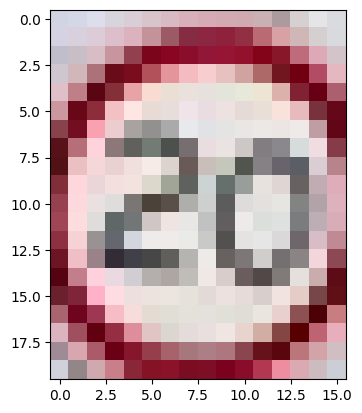

In [114]:
from PIL import Image
import matplotlib.pyplot as plt

#image = Image.open(image)
sign = crop_bounding_box(image, speedsign)
plt.imshow(sign)

In [108]:
sign_grayscale = sign.convert('L')

In [115]:
import numpy as np

sign_np = np.array(sign)
speed = reader.readtext(sign_np)
speed

[]

In [85]:
sign_np

array([[224, 228, 224, 231, 205, 206, 169,  78,  48,  36,  55,  87,  97,  90,  65,  37,  50,  64, 121, 193],
       [224, 226, 231, 202, 201, 140,  42,  40,  80, 171, 216, 228, 231, 232, 213, 175,  88,  50,  50, 100],
       [229, 222, 210, 198, 144,  45,  46, 135, 219, 228, 229, 228, 224, 227, 225, 229, 236, 127,  49,  37],
       [178, 178, 190, 173,  53,  35, 155, 224, 225, 229, 227, 229, 226, 228, 223, 226, 227, 229, 133,  51],
       [151, 165, 204,  82,  32, 145, 231, 225, 218, 213, 222, 235, 224, 224, 225, 223, 223, 223, 230, 101],
       [209, 196, 151,  33,  96, 214, 185,  95,  72,  75,  85, 191, 235, 230, 232, 199, 185, 216, 237, 201],
       [202, 199,  93,  45, 154, 224, 196, 154, 198, 194, 107,  84, 226, 235, 148,  62,  51,  69, 199, 227],
       [189, 176,  59,  63, 210, 225, 231, 237, 223, 229, 206,  67, 214, 173,  69, 181, 218, 106,  98, 218],
       [190, 153,  55,  87, 230, 224, 227, 233, 213, 170, 102, 104, 220,  98, 163, 240, 230, 203,  81, 200],
       [182, 146,  

In [37]:
speed_to_throttle(50)

0.42

In [17]:
image = np.array([[160, 186, 103, 104, 112, 106,  94, 115, 159, 185, 195, 198, 194,
        195, 184, 156, 105,  98, 109, 116, 102, 108, 186, 147],
       [169, 100,  99, 110,  91, 115, 169, 205, 202, 195, 199, 198, 194,
        196, 197, 198, 196, 165, 105,  93, 118, 107, 111, 187],
       [107, 109, 105,  90, 152, 200, 200, 201, 200, 197, 195, 195, 194,
        199, 197, 193, 199, 191, 195, 127,  89, 117,  99, 117],
       [103, 111,  98, 170, 205, 199, 199, 197, 195, 194, 196, 197, 198,
        194, 199, 197, 196, 200, 199, 200, 127,  97, 118, 100],
       [113,  92, 158, 208, 196, 200, 199, 205, 202, 196, 195, 200, 199,
        202, 201, 203, 198, 197, 199, 202, 207, 105, 102, 118],
       [ 97, 131, 212, 198, 202, 211, 203, 155, 188, 195, 200, 178, 182,
        188, 188, 193, 202, 195, 199, 192, 201, 177,  92, 115],
       [114, 191, 206, 200, 201, 170,  71,  40, 174, 202, 177,  58,  43,
         41,  39,  42,  40,  93, 204, 198, 206, 202, 130, 104],
       [149, 199, 202, 195, 197,  85,  58,  59, 187, 197, 171,  45, 100,
        119, 111, 104,  98, 129, 203, 191, 199, 193, 169, 102],
       [184, 199, 202, 199, 197, 179, 107,  55, 194, 198, 157,  39, 152,
        198, 207, 202, 194, 194, 205, 196, 194, 198, 188, 101],
       [199, 202, 198, 198, 199, 202, 112,  63, 200, 203, 137,  46, 147,
        148, 138, 150, 185, 204, 196, 198, 195, 199, 202, 107],
       [202, 193, 198, 199, 195, 205,  88,  72, 201, 203, 120,  32,  39,
         25,  36,  30,  70, 167, 200, 192, 198, 196, 201, 122],
       [202, 202, 199, 191, 202, 202,  67,  97, 203, 202, 183, 127, 137,
        170, 181, 145,  40,  78, 190, 198, 197, 198, 203, 121],
       [202, 198, 200, 197, 197, 198,  57, 112, 205, 199, 191, 199, 198,
        196, 194, 195, 133,  27, 185, 200, 196, 200, 203, 114],
       [206, 197, 199, 191, 199, 194,  47, 125, 201, 198, 193, 195, 194,
        193, 196, 195, 155,  24, 174, 200, 198, 196, 199,  94],
       [202, 197, 195, 197, 196, 182,  41, 138, 206, 202, 189, 200, 193,
        190, 201, 199, 110,  44, 190, 201, 198, 196, 187, 101],
       [190, 198, 192, 195, 197, 172,  35, 157, 208, 182,  59,  96, 148,
        180, 174, 129,  38, 106, 202, 191, 197, 199, 152,  99],
       [174, 198, 195, 193, 195, 168,  38, 180, 200, 177,  86,  32,  31,
         36,  31,  26,  92, 194, 194, 195, 193, 200, 110, 105],
       [136, 200, 203, 193, 194, 187, 178, 196, 194, 194, 193, 175, 145,
        120, 122, 165, 200, 200, 192, 198, 209, 157,  90, 112],
       [100, 172, 203, 191, 196, 192, 195, 195, 192, 196, 194, 191, 200,
        202, 201, 201, 195, 194, 195, 203, 181,  88, 109, 102],
       [106, 109, 191, 199, 194, 198, 194, 192, 192, 197, 192, 190, 193,
        193, 193, 191, 191, 194, 199, 195, 106, 100, 114,  87],
       [111, 108, 119, 185, 197, 194, 194, 194, 194, 195, 195, 193, 190,
        191, 191, 199, 189, 203, 185, 107,  96, 106,  95, 149],
       [ 94, 115, 100, 103, 171, 193, 195, 197, 194, 190, 191, 193, 192,
        193, 197, 199, 193, 152,  93,  92, 111,  90, 135, 183],
       [113,  96, 120, 102,  92, 127, 167, 199, 206, 205, 204, 203, 203,
        209, 189, 152, 107,  95, 104, 105,  80, 141, 179, 113],
       [186, 116,  88, 106, 109,  99,  85,  92, 116, 139, 154, 149, 127,
        100,  82,  88, 109, 106,  99,  91, 158, 184, 114, 204]],
      dtype=np.uint8)

In [18]:
# Recognize text from the image
results = reader.readtext(image)
print(results[0][1])

15
